In [17]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import scipy as sc
import scipy.stats as stats
import cartopy.crs as ccrs
# import pygrib
# import cfgrib
import stormeunice as eun
import warnings
import glob
import tqdm

sns.set_theme(style="white")
sns.set_style("white")

random.seed(10)

# Import data

In [2]:
# EPS

directory = '/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/'
eps = None
eps = []  # making sure to start from a clean slate

for ind, cont in enumerate(['cf', 'pf']):
    for files in glob.glob(directory+cont+'/*.nc'):
        print(files)
        if len(eps) == ind+1:
            data = xr.open_dataset(files)
            data = eun.data.Data.preproc_ds(data.get(['fg10', 'msl']))  # preprocessing just one variable for speed
            eps[ind] = xr.concat([eps[ind], data], dim = 'inidate')
        else:
            eps.append(eun.data.Data.preproc_ds(xr.open_dataset(files).get(['fg10', 'msl'])))

eps = xr.concat(eps, dim = 'number')

/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/cf/1_2022-02-16.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/cf/1_2022-02-14.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/cf/1_2022-02-10.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/pf/1_2022-02-14.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/pf/1_2022-02-10.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/pf/1_2022-02-16.nc


In [8]:
eps_GUST = eps.fg10.sel(time=slice('2022-02-07','2022-02-22'),latitude=slice(61,49),longitude=slice(-11,2)).resample(time='1d').max().load()

In [3]:
# ERA5

era5_2022 = xr.open_dataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/ERA5/EU025/sfc/2022.nc')
era5_GUST = era5_2022.fg10.sel(time=slice('2022-02-07','2022-02-22'),latitude=slice(61,49),longitude=slice(-11,2)).resample(time='1d').max().load()

In [4]:
# MIDAS observational data

MIDAS_station_info = pd.read_csv('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MIDAS/MIDAS_station_info.csv',index_col=0)
MIDAS_station_info['Station_name'] = MIDAS_station_info.Station_name.str.split('\n',expand=True)[0].str.strip()

def get_MIDAS_stations_near(lat,lon,n=1):
    
    dlat = np.deg2rad(MIDAS_station_info.Latitude - lat)
    dlon = np.deg2rad(MIDAS_station_info.Longitude - lon)
    
    a = np.sin(dlat/2.0)**2 + np.cos(lat) * np.cos(MIDAS_station_info.Latitude) * np.sin(dlon/2.0)**2
    
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        D = np.arcsin(np.sqrt(a))
    
    return MIDAS_station_info.loc[D.sort_values().index[:n],'src_id'].values

In [5]:
MIDAS_2022 = pd.read_csv('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MIDAS/wind/midas_wind_202201-202212.txt',
            names=[x.strip() for x in pd.read_csv('https://dap.ceda.ac.uk/badc/ukmo-midas/metadata/table_structures/WMTB.txt',header=None).values.flatten()])

MIDAS_2022 = MIDAS_2022.apply(lambda x: x.replace(' ',np.nan).astype(float)*0.514444 if x.name[-5:]=='SPEED' else x)
MIDAS_2022['OB_END_TIME'] = pd.to_datetime(MIDAS_2022.OB_END_TIME)

/tmp/user/27529/ipykernel_546229/1519396007.py:1: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  MIDAS_2022 = pd.read_csv('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MIDAS/wind/midas_wind_202201-202212.txt',


In [6]:
MIDAS_2022_GUST = MIDAS_2022[['OB_END_TIME','SRC_ID','MAX_GUST_SPEED']]
MIDAS_2022_GUST = MIDAS_2022_GUST.groupby('SRC_ID').resample('1d',on='OB_END_TIME').max().dropna()
MIDAS_2022_GUST[['Latitude','Longitude']] = MIDAS_station_info.set_index('src_id').loc[MIDAS_2022_GUST.SRC_ID.astype(int),['Latitude','Longitude']].values

# Stamp plot differences

### ERA5

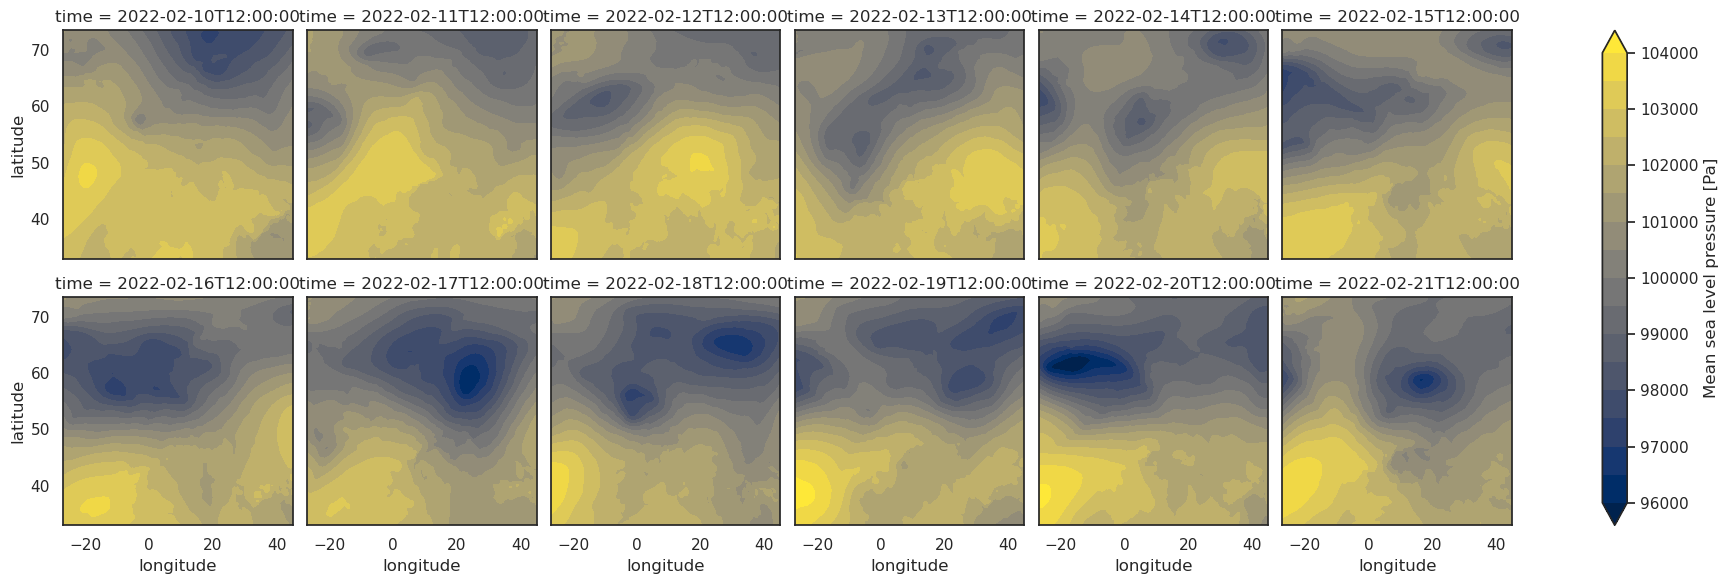

In [14]:
era5_2022.sel(time=era5_2022.time.dt.hour==12).sel(time=slice('2022-02-10','2022-02-21')).msl.plot.contourf(vmin=96000,vmax=104000,col='time',col_wrap=6,levels=17,cmap='cividis')

### Forecasts

In [19]:
for inidate in tqdm.tqdm(eps.inidate):
    eps.sel(inidate=inidate,time='2022-02-18 12').msl.squeeze().plot.contourf(col='number',col_wrap=10,vmin=96000,vmax=104000,levels=17,cmap='cividis')
        
''

  0%|          | 0/3 [00:00<?, ?it/s]


AttributeError: 'Dataset' object has no attribute 'msl'

# Plumes of wind gusts

### Heathrow

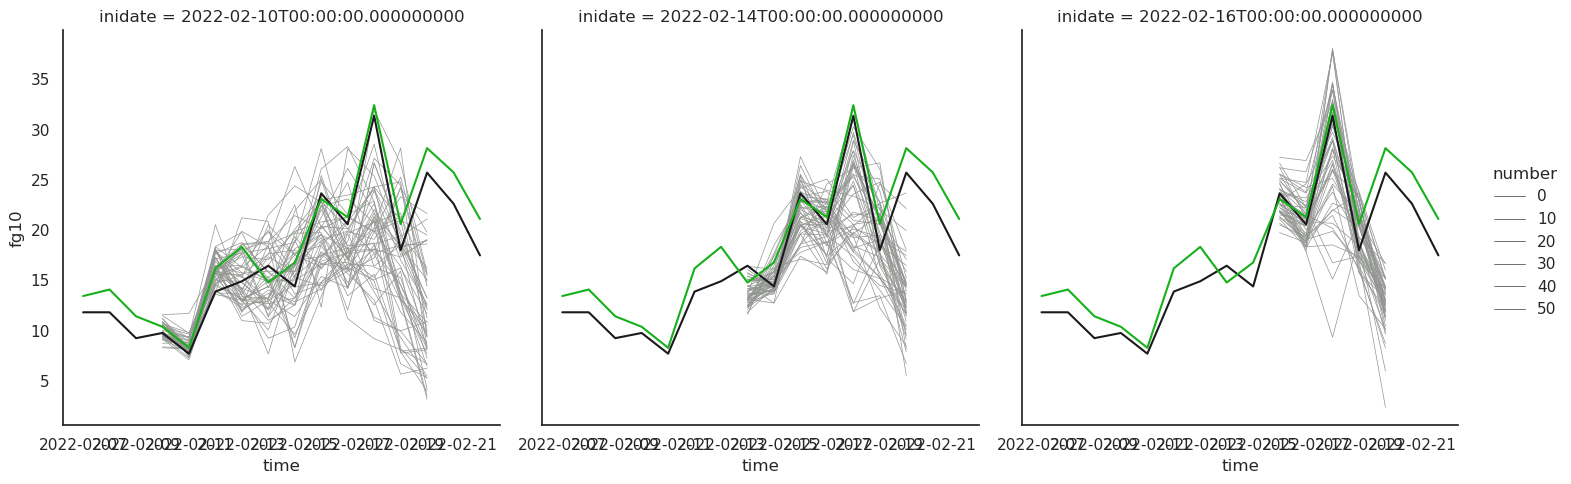

In [10]:
g = sns.relplot(data=eps_GUST.sel(latitude=51.48,longitude=-0.449,method='nearest').to_dataframe().reset_index(),x='time',y='fg10',col='inidate',size='number',sizes=(0.5,0.5),col_wrap=3,kind='line',color='xkcd:grey')

g.map(lambda x, **kwargs: sns.lineplot(data=MIDAS_2022_GUST.loc[(get_MIDAS_stations_near(lat=51.48,lon=-0.449,n=1),slice('2022-02-07','2022-02-22')),:].MAX_GUST_SPEED.reset_index(),x='OB_END_TIME',y='MAX_GUST_SPEED',**kwargs),'time',color='k',zorder=5,lw=1.5)

g.map(lambda x, **kwargs: sns.lineplot(data=era5_GUST.sel(latitude=51.48,longitude=-0.449,method='nearest').to_dataframe().reset_index(),x='time',y='fg10',**kwargs),'time',color='xkcd:green',zorder=5,lw=1.5)

#plt.savefig('../../Output/Figures/inidate-selection/HEATHROW-fg10-plume.png')

### Strongest wind stations

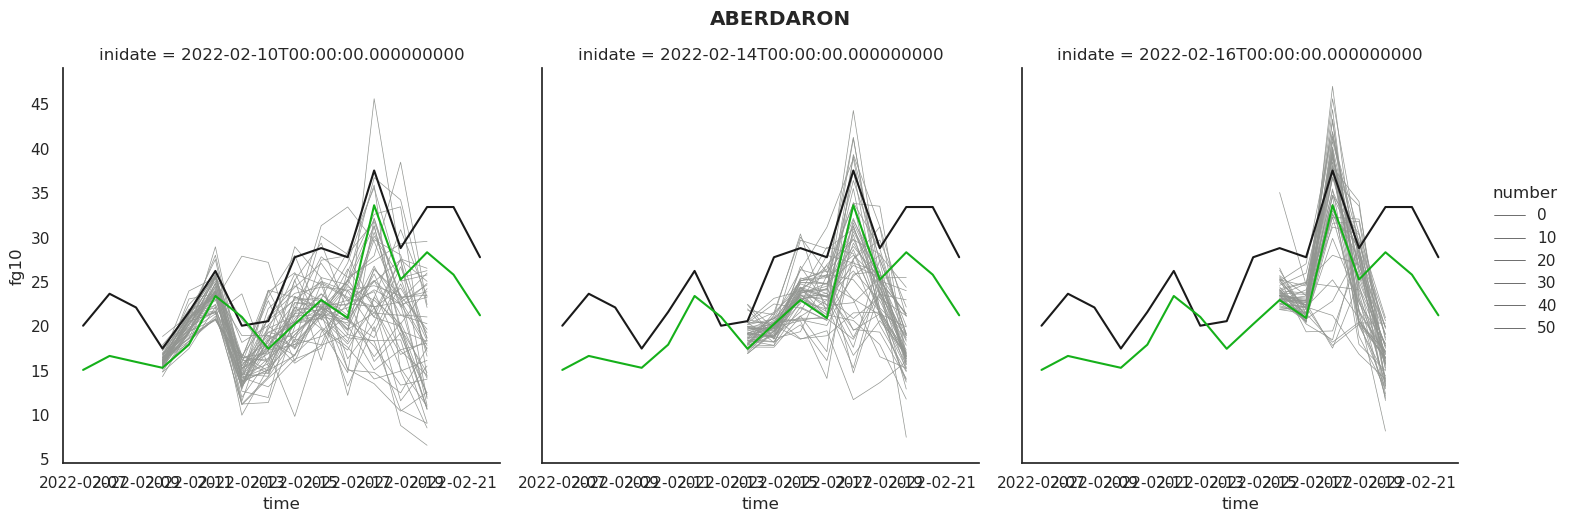

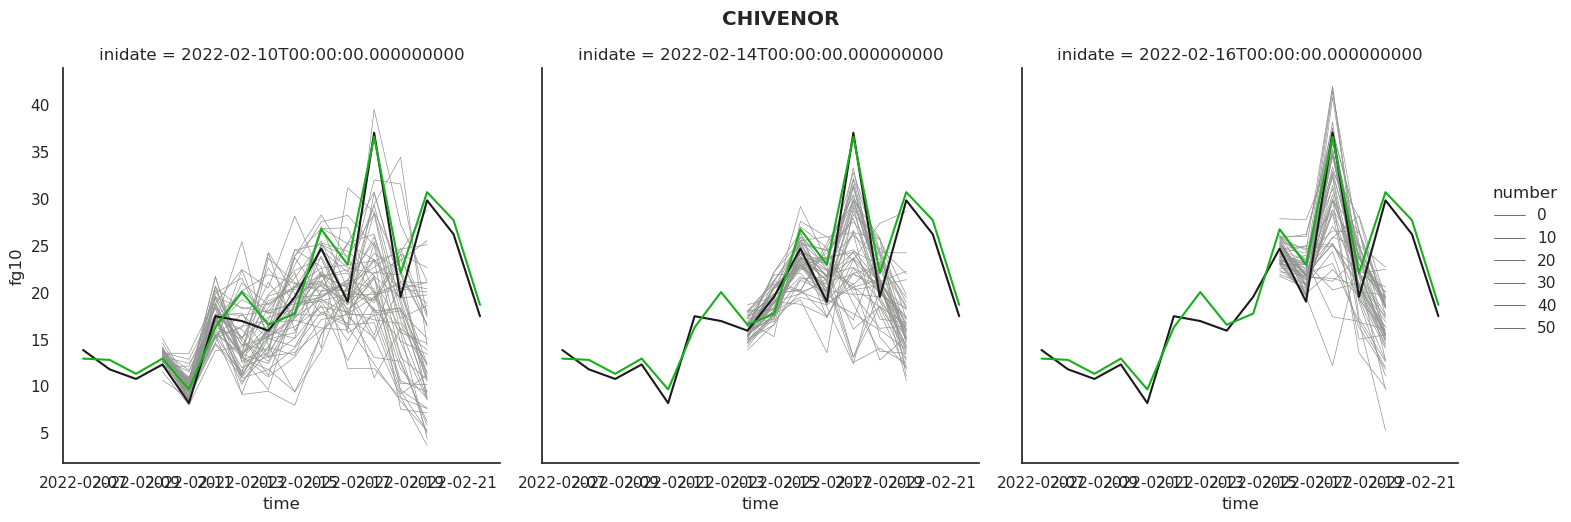

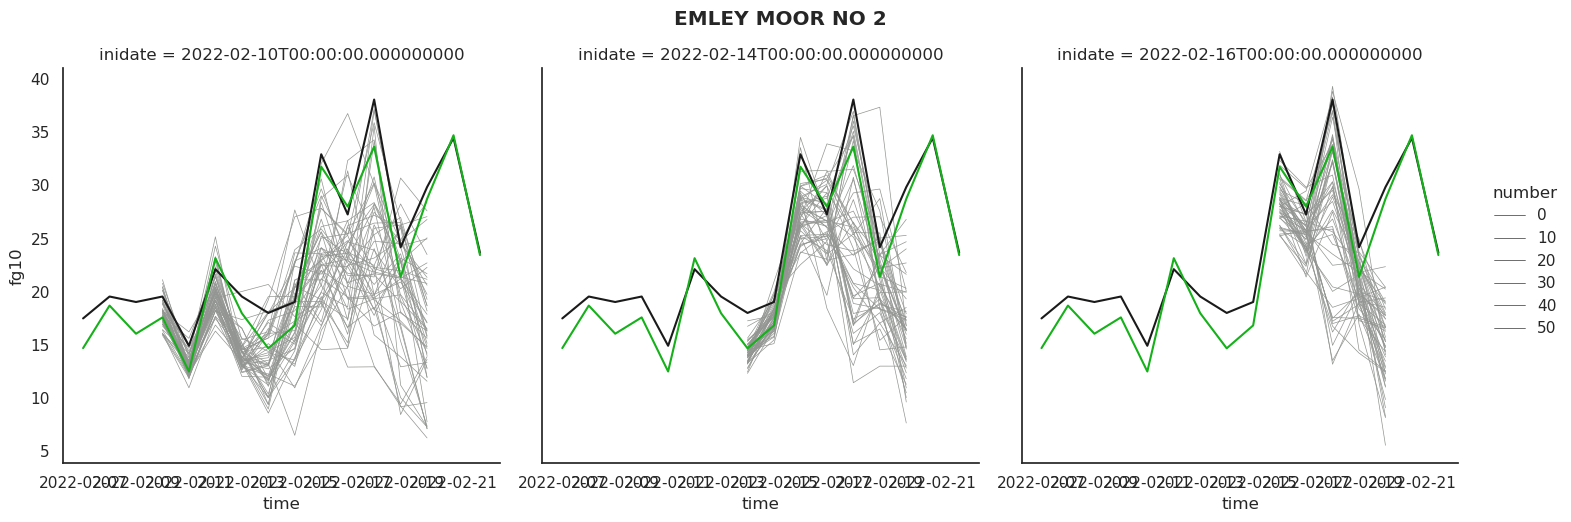

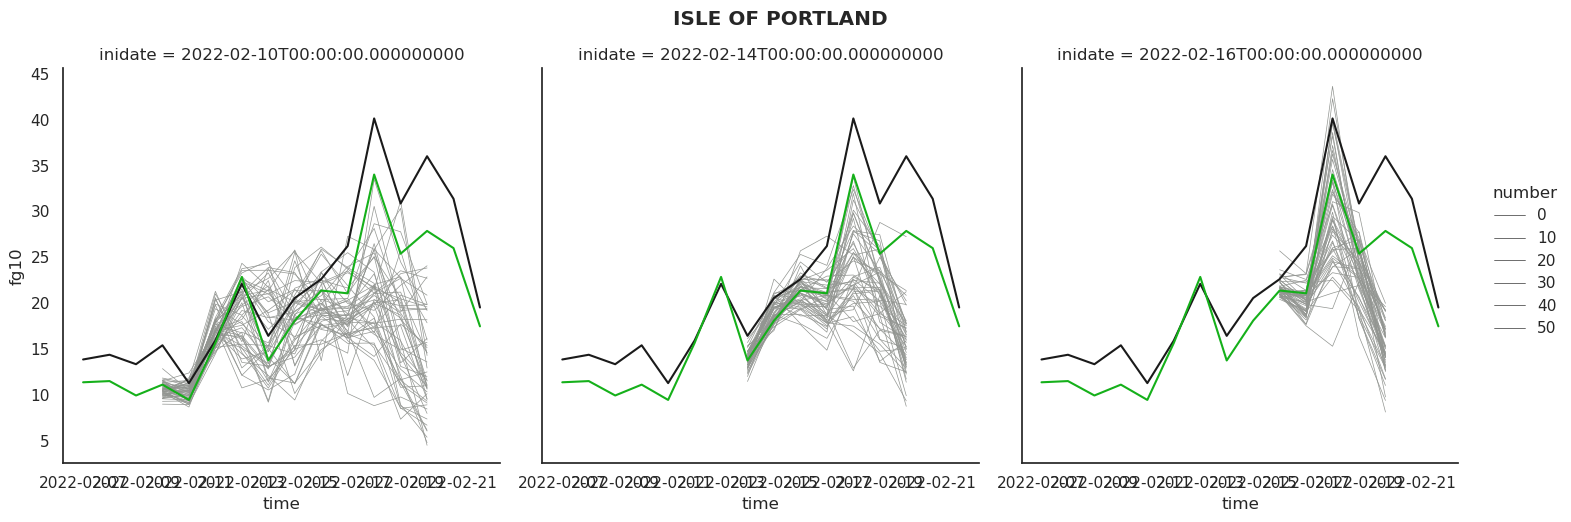

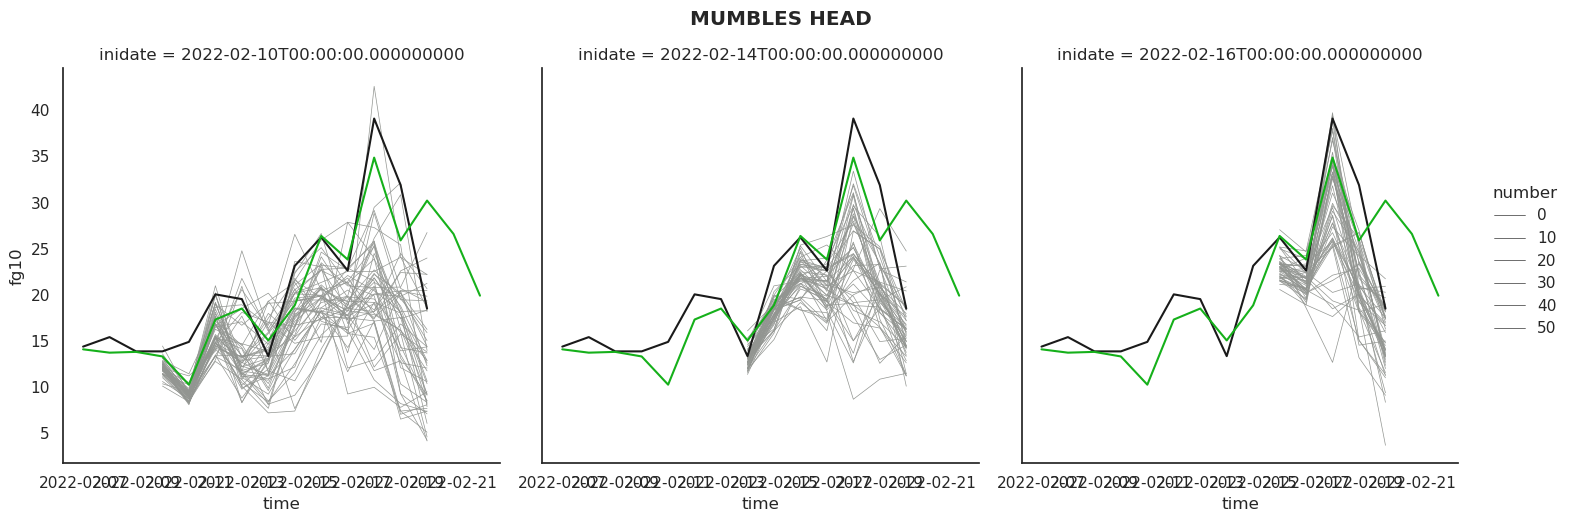

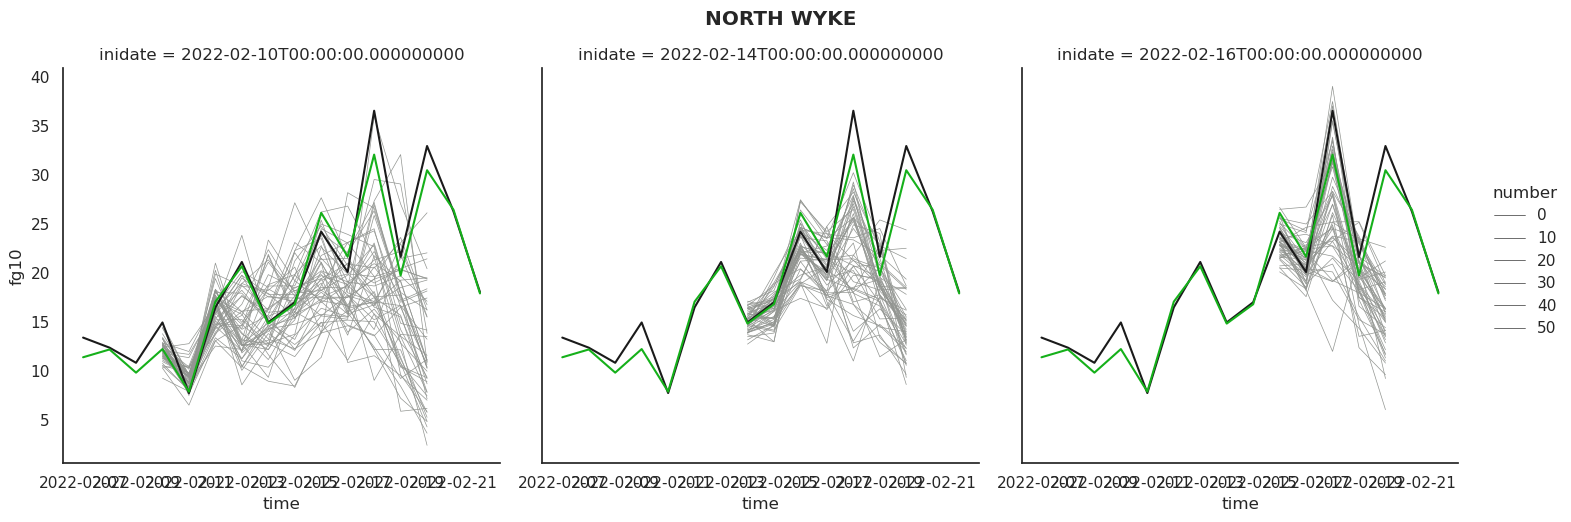

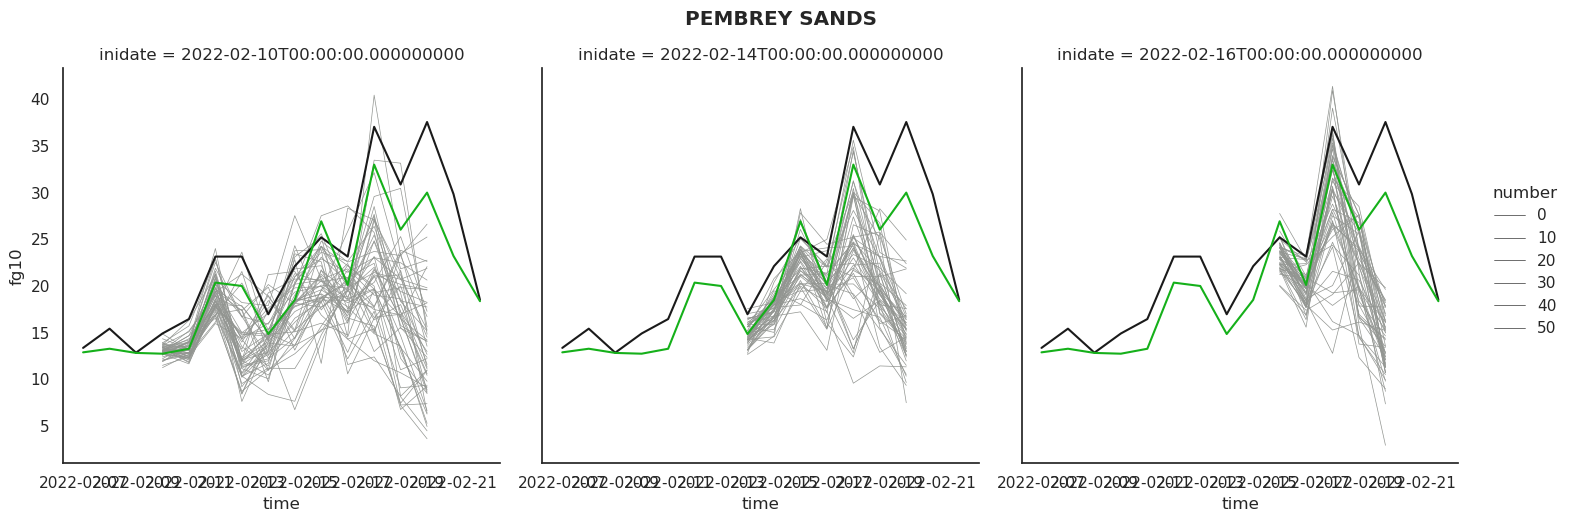

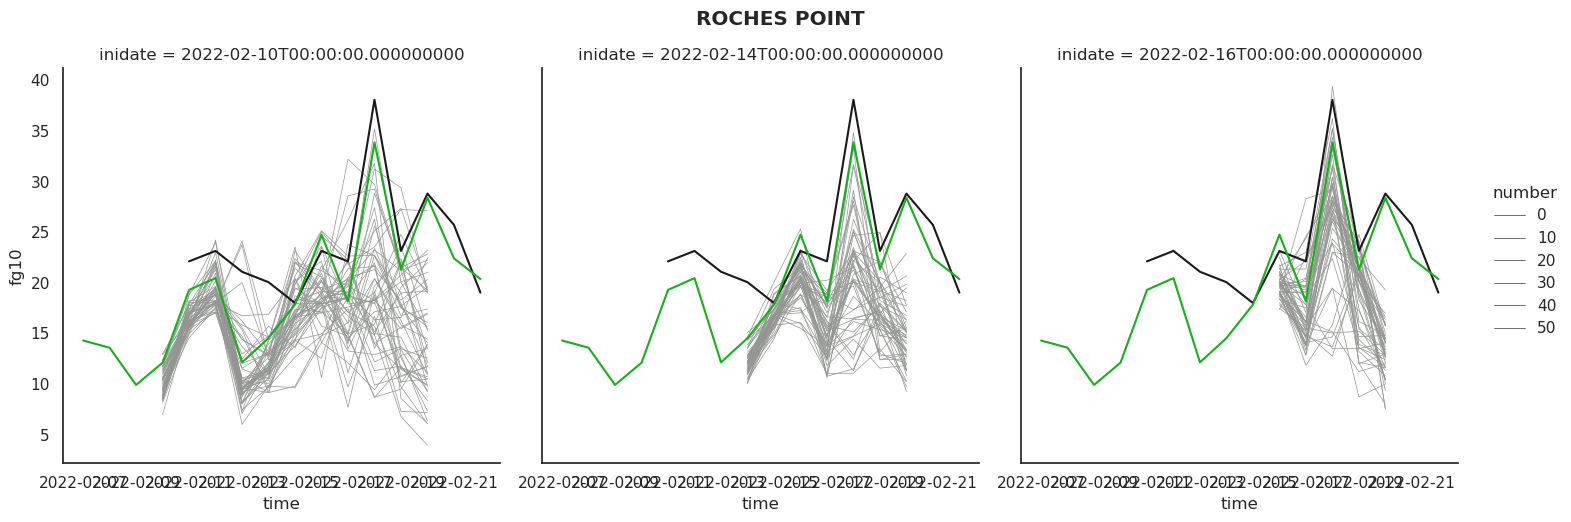

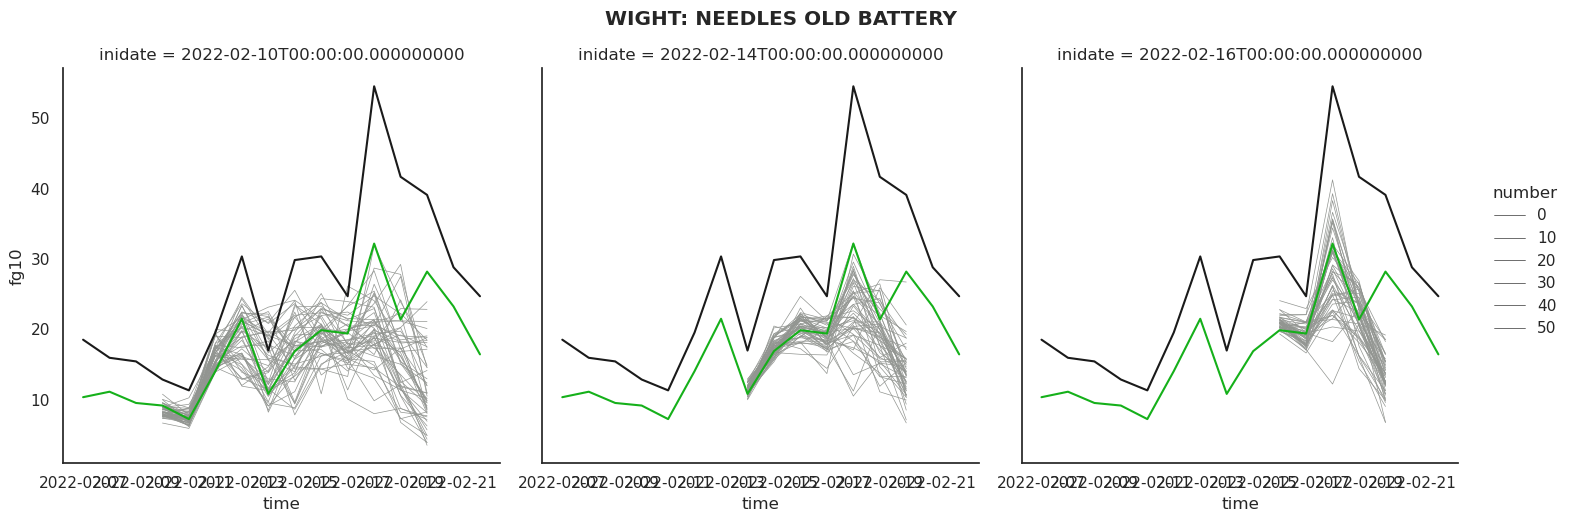

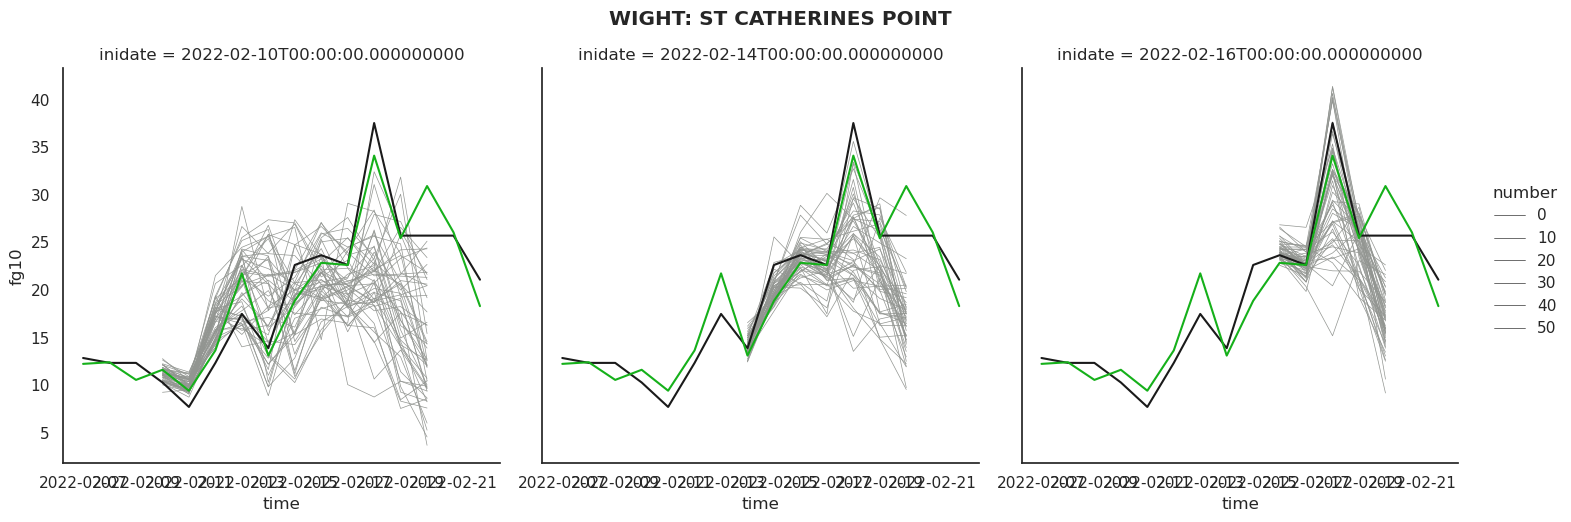

In [13]:
for row,s in MIDAS_station_info.loc[MIDAS_station_info.src_id.isin(MIDAS_2022_GUST.loc[(slice(None),'2022-02-18'),:].groupby(level=0).max().MAX_GUST_SPEED.sort_values().index[-10:])].iterrows():
    
    g=sns.relplot(data=eps_GUST.sel(latitude=s.Latitude,longitude=s.Longitude,method='nearest').to_dataframe().reset_index(),x='time',y='fg10',col='inidate',size='number',sizes=(0.5,0.5),col_wrap=3,kind='line',color='xkcd:grey')

    g.map(lambda x, **kwargs: sns.lineplot(data=MIDAS_2022_GUST.loc[(s.src_id,slice('2022-02-07','2022-02-22')),:].MAX_GUST_SPEED.reset_index(),x='OB_END_TIME',y='MAX_GUST_SPEED',**kwargs),'time',color='k',zorder=5,lw=1.5)
    
    g.map(lambda x, **kwargs: sns.lineplot(data=era5_GUST.sel(latitude=s.Latitude,longitude=s.Longitude,method='nearest').to_dataframe().reset_index(),x='time',y='fg10',**kwargs),'time',color='xkcd:green',zorder=5,lw=1.5)
    
    g.fig.suptitle(s.Station_name,fontweight='bold',y=1.04)